In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('./Data/MtWashingtonDailyTemps.csv', index_col='DATE',parse_dates=True)

In [19]:
df

,MinTemp,MaxTemp,AvgTemp,AvgWindSpeed,Sunrise,Sunset
DATE,,,,,,
2014-12-01,3,36,20,65.1,700,1608
2014-12-02,1,22,12,34.7,702,1607
2014-12-03,8,32,20,53.0,703,1607
2014-12-04,-5,9,2,60.2,704,1607
2014-12-05,6,17,12,30.5,705,1607
...,...,...,...,...,...,...
2018-11-26,14,25,20,26.6,655,1610
2018-11-27,12,18,15,43.0,656,1609
2018-11-28,11,16,14,29.4,657,1609


# Train Test Split

In [23]:
n_obs = 60

In [28]:
train = df.iloc[:-n_obs]
test = df.iloc[-n_obs:]

# Scale Data

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()

In [33]:
scaler.fit(train)

MinMaxScaler()

In [34]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [37]:
length = 30
batch_size = 1
gen = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [38]:
print(len(scaled_train),len(gen))

1401 1371


# Model

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input

from tensorflow.keras.callbacks import EarlyStopping

In [44]:
scaled_train.shape

(1401, 6)

In [237]:
inputs = Input(shape=(length, scaled_train.shape[1]))
x = LSTM(50, activation='tanh', return_sequences=True)(inputs)
x = LSTM(50)(x)
x = Dense(scaled_train.shape[1])(x)
model = Model(inputs, x)

In [238]:
model.compile(loss='mse', optimizer='adam')

In [239]:
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30, 6)]           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 30, 50)            11400     
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 306       
Total params: 31,906
Trainable params: 31,906
Non-trainable params: 0
_________________________________________________________________


In [240]:
es = EarlyStopping(monitor='val_loss', patience=3)

In [241]:
gen_val = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [242]:
hist = model.fit(gen, epochs=20, validation_data=gen_val, callbacks=[es])

Epoch 1/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 2/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 3/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0098 - val_loss: 0.0123
Epoch 4/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0088 - val_loss: 0.0122
Epoch 5/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0085 - val_loss: 0.0115
Epoch 6/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0082 - val_loss: 0.0117
Epoch 7/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0081 - val_loss: 0.0123
Epoch 8/20
1371/1371 [==============================] - 5s 4ms/step - loss: 0.0079 - val_loss: 0.0119


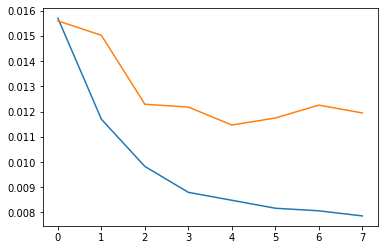

In [243]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [244]:
first_eval_batch = scaled_train[-length:]

In [245]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [246]:
model.predict(first_eval_batch)

array([[0.72352123, 0.7395909 , 0.7417531 , 0.29007798, 0.52206457,
        0.35132027]], dtype=float32)

In [247]:
scaled_test[0]

array([0.76      , 0.73333333, 0.75824176, 0.29017341, 0.446875  ,
       0.36391437])

In [248]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [249]:
test_predictions

[array([0.72352123, 0.7395909 , 0.7417531 , 0.29007798, 0.52206457,
        0.35132027], dtype=float32),
 array([0.71693397, 0.7350317 , 0.73801994, 0.31308   , 0.54386425,
        0.3325676 ], dtype=float32),
 array([0.70234716, 0.7181699 , 0.7213243 , 0.3147715 , 0.5668769 ,
        0.31207243], dtype=float32),
 array([0.6943413 , 0.7091519 , 0.7119957 , 0.31749701, 0.58947885,
        0.29267758], dtype=float32),
 array([0.68789136, 0.7023872 , 0.70484054, 0.32145792, 0.60998285,
        0.27373946], dtype=float32),
 array([0.67991686, 0.69393116, 0.69586575, 0.32598013, 0.62904984,
        0.25530228], dtype=float32),
 array([0.6706804 , 0.68405664, 0.68531907, 0.33101866, 0.6471485 ,
        0.237468  ], dtype=float32),
 array([0.66064507, 0.67335445, 0.67385364, 0.33648053, 0.6644982 ,
        0.22028011], dtype=float32),
 array([0.64979327, 0.6618361 , 0.6614702 , 0.34231794, 0.681314  ,
        0.2038464 ], dtype=float32),
 array([0.63802886, 0.64937794, 0.64807   , 0.34845817,

In [250]:
predictions = scaler.inverse_transform(test_predictions)

In [251]:
predictions_df = pd.DataFrame(data=predictions, columns=test.columns)

In [252]:
columns = test.columns

In [253]:
predictions_df.set_index(test.index, inplace=True)

In [254]:
test.head()

,MinTemp,MaxTemp,AvgTemp,AvgWindSpeed,Sunrise,Sunset
DATE,,,,,,
2018-10-02,36,47,42,29.8,544,1725
2018-10-03,45,52,49,17.4,545,1723
2018-10-04,32,54,43,48.3,546,1721
2018-10-05,32,50,41,23.9,547,1719
2018-10-06,35,51,43,37.6,549,1717


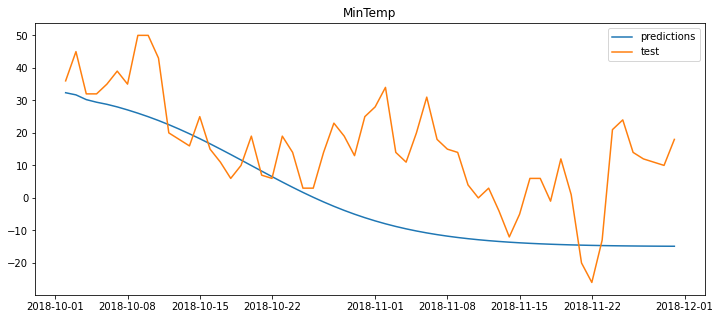

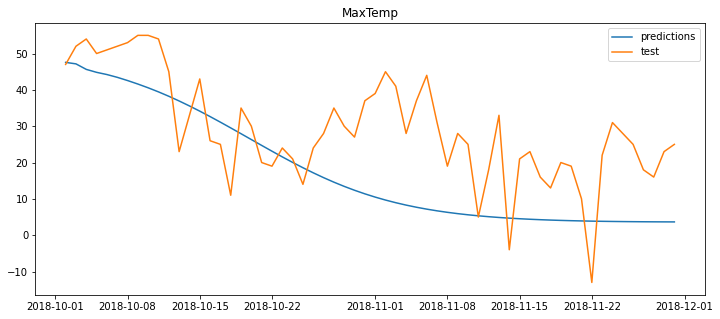

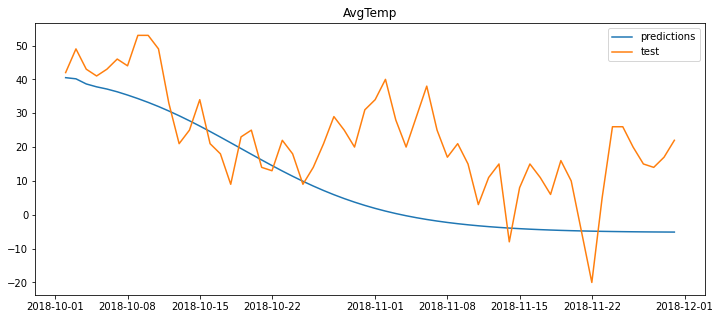

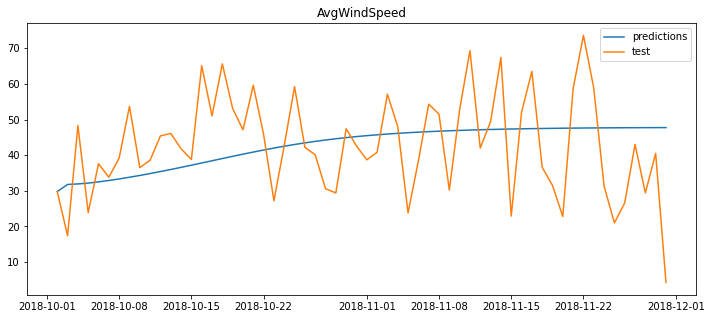

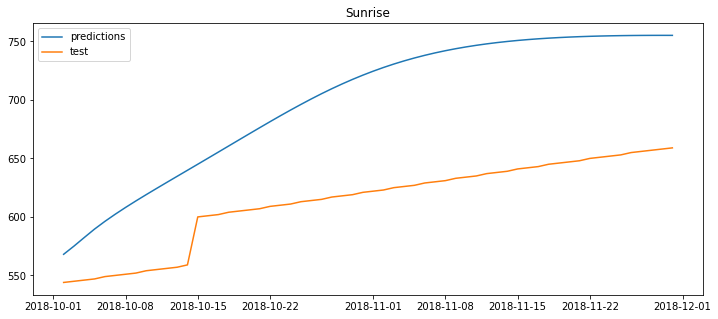

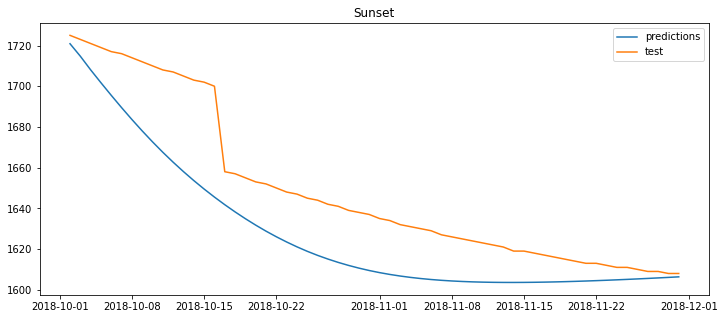

In [255]:
for column in columns:
    plt.figure(figsize=(12,5))
    plt.plot(predictions_df[column], label='predictions')
    plt.plot(test[column], label='test')
    plt.legend()
    plt.title(column)
    plt.show()